<a href="https://colab.research.google.com/github/emmanuellfc/EM_Tufts_Fall2023/blob/main/GeneralFiniteDifferences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Package dependencies.
!apt install libcgal-dev libeigen3-dev
!pip install -U pygalmesh
!pip install networkx

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgmp-dev libgmpxx4ldbl libmpfr-dev
Suggested packages:
  libmpfi-dev libntl-dev libeigen3-doc libmpfrc++-dev gmp-doc libgmp10-doc libmpfr-doc
The following NEW packages will be installed:
  libcgal-dev libeigen3-dev libgmp-dev libgmpxx4ldbl libmpfr-dev
0 upgraded, 5 newly installed, 0 to remove and 19 not upgraded.
Need to get 6,457 kB of archives.
After this operation, 52.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgmpxx4ldbl amd64 2:6.2.1+dfsg-3ubuntu1 [9,580 B]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgmp-dev amd64 2:6.2.1+dfsg-3ubuntu1 [337 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libmpfr-dev amd64 4.1.0-3build3 [271 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcgal-dev amd64 5.4-1 [4,784 kB]
Get:5 http://archive.u

In [ ]:
# Imports.
import pygalmesh
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections.abc import Iterable
import math

In [ ]:
# Rperesents an individual node of the graph data structure representation of the mesh.
class MeshPoint: pass
class MeshPoint:
  def __init__(self,pos: tuple = (0,0)):
    self.pos = tuple(pos) # (x,y) position of the node.
    self.pot: float = 0 # Solution of potential for this node point.
  def __getitem__(self,index):
    return self.pos[index]
  def __eq__(self,other: MeshPoint):
    return self.pos is other.pos
  def __hash__(self):
    return hash(self.pos)

  # The "gamma" function is one half the sum of inverse square distances between these points. i.e. 0.5(1/(x1-x2)^2 + 1/(y1-y2)^2).
  def gamma(self,other: MeshPoint) -> float:
    if  len(self.pos) is not len(other.pos):
      raise Exception('Incompatable dimensionality computing gamma: ' + self.pos + ' and ' + other.pos)
    tmp: float = 0
    for dim in range(len(self.pos)):
      # Don't divide by 0.
      if math.isclose(self.pos[dim],other.pos[dim]): continue
      tmp += pow(self.pos[dim]-other.pos[dim],-2)
    return tmp/2

# Represents a mesh (contains a graph) for the system we're trying to solve.
class FiniteDifferences:
  def __init__(self):
    self.edge_points: list = None # List of (x,y) points that form the boundary of the 2D space.
    self.mesh = None # Pygalmesh mesh object.
    self.mesh_points: list = None # List of (x,y) points that form the region of 2D space.
    self.graph = nx.Graph() # Graph data structure representing the region. Nodes of the graph are MeshPoint objects.
    self.boundary_conditions = [] # Not sure what the elements of this will look like yet.
    self.systems_matrix = None # m x m matrix where m is the number of points in the space.

  # Make a list of points from some edge conditions. This makes a surface "mesh" from a boundary definition. The boundary is a list of points.
  def make_points_from_boundary(self,boundary: Iterable[tuple]):
    # First, store the edge points that we were passed.
    self.edge_points = list(boundary())
    # The constraints we pass to pygalmesh need to look like [(0,1),(1,2),...(n-2,n-1),(n-1,0)]. The last constraint closes the boundary.
    constraints = [ (i-1,i) for i in range(1,len(self.edge_points)) ] + [(len(self.edge_points)-1,0)]
    # Ask pygalmesh to make a mesh for us.
    self.mesh = pygalmesh.generate_2d(
      self.edge_points,
      constraints,
      max_edge_size=5e-1,
      num_lloyd_steps=10,
    )
    # Store the points from this mesh as MeshPoint objects.
    self.mesh_points = [ MeshPoint(pt) for pt in self.mesh.points ]

  # Only callable once a mesh exists. Build a graph data structure from a list of points. Don't make neighbors out of points that are too far away.
  def make_graph_from_points(self):
    # First, add all mesh points to the graph as nodes.
    for point in self.mesh_points:
      self.graph.add_node(point)
    # Now, for each point...
    for point in self.mesh_points:
      # Get gamma values for all of the other points...
       # This makes a copy of our point list with the closest gamma points first. NEARER points have LARGER gamma values.
      points_gammas = sorted(self.mesh_points,key=lambda other_point: point.gamma(other_point),reverse=True)
      # Keep the nearest 10 points... TODO: Make this more general/parametrized?
      # Add edges between this point and "nearby" points.
      for other_point in points_gammas[:3]:
        if point == other_point: continue # Don't try to link a point to itself! (This shouldn't really be possible.)
        # Make the edge between these points.
        self.graph.add_edge(point,other_point,gamma=point.gamma(other_point))

  # Only callable once a graph exists. Make the C matrix element by element.
  def make_systems_matrix(self):
    # Initialize the systems matrix to the correct size (m x m where m is our number of points).
    m = len(self.mesh_points)
    self.systems_matrix = np.array([np.zeros(m) for j in range(m)])
    # c_{i,i} = -1, so fill that diagonal now.
    for i in range(0,m): self.systems_matrix[i][i] = -1
    # Iterate over nodes of the graph...
    for point in self.mesh_points:
      # What is the index of this point? (We need this later.)
      i_point = self.mesh_points.index(point)
      # ... and get the edges for this point (its neighbors).
      # For each of these, c_{i,j} = gamma_{i,j} / (k el neighbors(i) sum gamma_{i,k}).
      # self.graph[point] is a dict of { neighbor_point : attributes } elements. We expect attributes to contain a gamma attribute.
      neighbors = self.graph[point]
      # First get the gamma sum for this point (depends on all neighbors).
      gamma_sum: float = 0
      for neighbor in neighbors:
        gamma_sum += self.graph[point][neighbor]['gamma']
      # Iterate over neighbors now and fill in c_{i,j} elements.
      for neighbor in neighbors:
        # What is the index of the neighbor?
        i_neighbor = self.mesh_points.index(neighbor)
        self.systems_matrix[ i_point ][ i_neighbor ] = self.graph[point][neighbor]['gamma'] / gamma_sum

  # Inform the method of boundary conditions that exist for the problem.
  def inform_with_boundary_condition(self):
    pass

  # Only callable once a C matrix exists. Try to solve the C matrix.
  def solve_systems_matrix(self):
    pass

  # Profit???

[[-1.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.30636715
   0.          0.30636715  0.          0.          0.          0.
   0.          0.          0.38726569]
 [ 0.         -1.          0.          0.          0.          0.
   0.          0.          0.          0.          0.29614678  0.
   0.          0.          0.          0.29614678  0.          0.
   0.          0.40770645  0.        ]
 [ 0.          0.         -1.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.30301141  0.          0.30301141  0.          0.          0.39397717
   0.          0.          0.        ]
 [ 0.          0.          0.         -1.          0.          0.
   0.          0.          0.          0.30245916  0.          0.
   0.          0.          0.          0.          0.30245916  0.
   0.39508168  0.          0.        ]
 [ 0.          0.          0.       

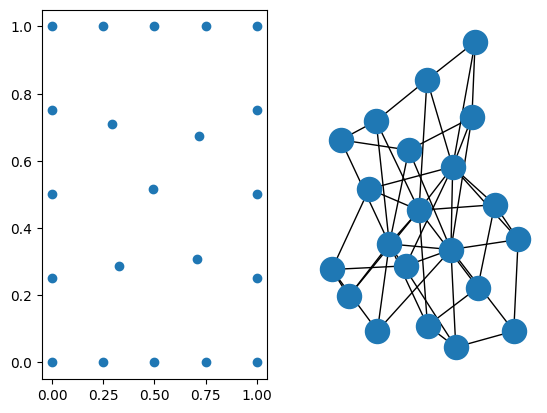

In [ ]:
# Generate the simplest possible boundary: An edge length 1 box.
def box_generator():
  yield (0,0)
  yield (0,1)
  yield (1,1)
  yield (1,0)

solution = FiniteDifferences()
solution.make_points_from_boundary(box_generator)

plt.subplot(121)
plt.scatter([ loc[0] for loc in solution.mesh_points ],[ loc[1] for loc in solution.mesh_points ])

solution.make_graph_from_points()

plt.subplot(122)
nx.draw(solution.graph)

solution.make_systems_matrix()
print(solution.systems_matrix)